In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Test of pipeline

## Step 1: Setup `Survey` parameters

### Galaxy properties

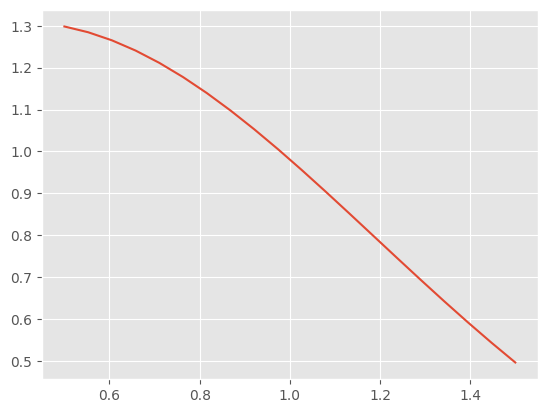

In [3]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

plt.plot(zs, pz)

### CIB Properties

In [4]:
nu_obs = [353, 545, 857] # Planck effective freq. in GHz

# load Planck filter response curves 
from galCIB.utils.io import load_my_filters

cib_filters = load_my_filters("/Users/tkarim/research/galCIB/data/filters/",
                nu_obs=nu_obs)

## Step 2: Setup `Survey`

In [5]:
from galCIB import Survey 

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
NSIDE = 1024 
mag_alpha = 2.225 

elg_survey = Survey(z=zs, 
                 pz=pz, mag_alpha=mag_alpha,  # galaxy-specific
                 cib_filters=cib_filters,  # dict: freq_GHz -> (freq_array_Hz, response_array)
                 ells=ells, nside=NSIDE,
                 name="DESI-Planck")

## Step 3: Setup `Cosmology`

In [6]:
ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

from galCIB import Cosmology

cosmo = Cosmology(elg_survey.z, ks, Mh, colossus_cosmo_name='planck18',
                  use_little_h=False)

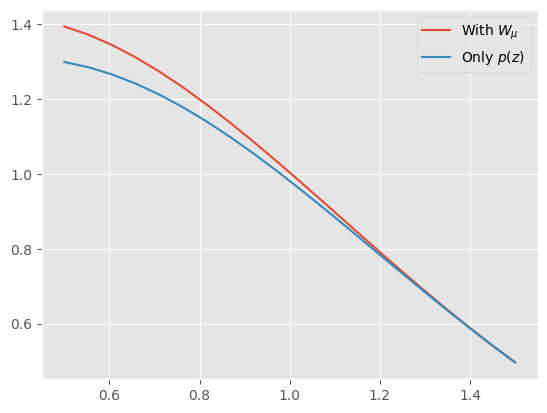

In [7]:
# Calculate window 

elg_survey.compute_windows(cosmo,True)
plt.plot(cosmo.z, elg_survey.Wg, label = r'With $W_{\mu}$')
plt.plot(zs, pz, label = r'Only $p(z)$')
plt.legend(loc='best')

## Step 4: Setup `HODModel` by using default model "DESI-ELG"

In [8]:
# Setup galaxy HOD

from galCIB import get_hod_model
elg_hod_model = get_hod_model("DESI-ELG", cosmo)

## Step 5: Setup `SatProfile` 

Satellite galaxy profile in the $1$-halo term.

In [9]:
# Setup Satellite Profile Model 

from galCIB import SatProfile

theta_sat = np.array([0.58, 6.14, 0.67])
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='mixed')

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


## Step 6: Setup `CIBModel` and its submodule classes

### Step 6a: Setup `SFRModel` 

Using default SFR Model "M21" and applying the `HODModel` "Zheng05" on the IR-emitting galaxies. 

In [10]:
from galCIB import SFRModel

# IR-emitting galaxies  HOD model 
hod_IR = get_hod_model("Zheng05", cosmo)

# Default SFR model
sfr_model = SFRModel(name="M21", hod=hod_IR, cosmo=cosmo)

### Step 6b: Setup `SnuModel`

Using the default parametric "Y23" and the non-parametric "M21" models. 

#### Step 6bI : Setup "Y23" 

Test this model.

In [11]:
from galCIB import SnuModel

# Parametric Snu model (Y23)
snu_model_Y23 = SnuModel(name="Y23", cosmo=cosmo)

##### Combine at the level of `CIBModel` 

Calculate djc and djsub.

In [12]:
from galCIB import CIBModel 

# Initialize CIB model
cib_Y23 = CIBModel(sfr_model=sfr_model, 
                   snu_model=snu_model_Y23,
                   hod_IR=hod_IR,
                   survey=elg_survey,
                   cosmo=cosmo
                   )

In [13]:
# Parameters
theta_sfr = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.40, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

In [14]:
# Update cache
cib_Y23.update(theta_sfr, theta_snu, theta_IR)

# Access emissivities
djc = cib_Y23.get_djc()
djsub = cib_Y23.get_djsub()

filt_freq = (12930,)
filt_response = (12930,)
(20, 10000)
norm shape = 83804150415.93488
filt_freq = (16819,)
filt_response = (16819,)
(20, 10000)
norm shape = 220319224671.95984
filt_freq = (13938,)
filt_response = (13938,)
(20, 10000)
norm shape = 147304780630.5392


## Step 7: Setup `PkBuilder` 

In [16]:
from galCIB import PkBuilder

In [17]:
pk_survey = PkBuilder(cosmology=cosmo,
                      hod_model=elg_hod_model,
                      cib_model=cib_Y23,
                      prof_model=elg_sat_profile
                      )

In [29]:
# compute pk

theta_cen = np.array([5.47, 11.64, 0.30, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.41, 10**11.20, 10**13.84, 1]) # As, M0, M1, alpha_sat
theta_prof = np.array([0.58, 6.14, 0.67]) # fexp, tau, lambda_NFW
#theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

theta_sfr = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.40, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
theta_IR = np.array([11.47, 1.22, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM

pgg, pII, pgI = pk_survey.compute_pk(theta_cen=theta_cen,
                     theta_sat=theta_sat,
                     theta_prof=theta_prof,
                     theta_sfr=theta_sfr,
                     theta_snu=theta_snu,
                     theta_IR_hod=theta_IR,
                     hmalpha=1)

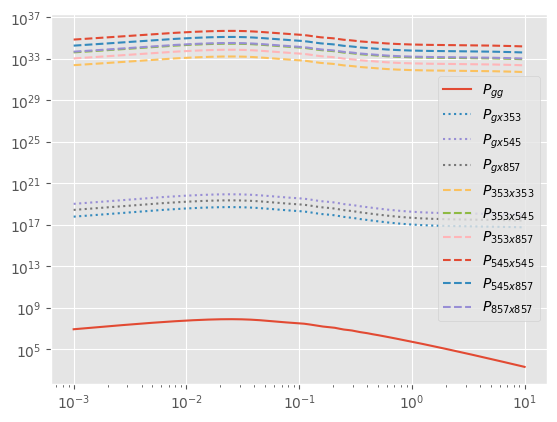

In [44]:
zidx = 5
plt.loglog(cosmo.k, pgg[:,zidx], label = r'$P_{gg}$')

nulist = ['353', '545', '857']

for i in range(3):
    plt.loglog(cosmo.k, pgI[i,:,zidx],
               label = fr'$P_{{gx{nulist[i]}}}$',
               ls = 'dotted')
    
for i in range(6):
    a,b = pk_survey.twoh_pairs[i]
    plt.loglog(cosmo.k, pII[i,:,zidx],
               label = fr'$P_{{{nulist[a]}x{nulist[b]}}}$',
               ls = 'dashed')

plt.legend(loc='best')

Non-Parametric Model

In [111]:
snu_model_M21(None)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_15087/441429799.py", line 1, in <module>
    snu_model_M21(None)
  File "/Users/tkarim/research/galCIB/src/galCIB/cib/snumodel.py", line 28, in __call__
    return self.model_fn(theta_snu)
TypeError: snu_M21_factory.<locals>.snu_M21() missing 2 required positional arguments: 'nu' and 'z'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1112, in structured

In [114]:
snu_model_M21(theta_snu).shape

(200, 210)

In [112]:
# Non-parametric Snu model (M21) from tabulated files
snu_model_M21 = SnuModel(name="M21", cosmo=cosmo,
                         data_dir="../data/")

# Initialize CIB model
cib_M21 = CIBModel(
    sfr_model=sfr_model,
    snu_model=snu_model_M21,
    hod_IR=hod_IR,
    cosmo=cosmo
)

# Update (same theta_sfr and theta_hod as above, but no theta_snu needed)
cib_M21.update(theta_sfr, theta_snu=None, theta_hod_IR=theta_IR)

# Get emissivities
djc_M21 = cib_M21.djc()
djsub_M21 = cib_M21.djsub()

ValueError: operands could not be broadcast together with shapes (200,1,210) (1,100,20) 

In [13]:
from astropy.io import fits

In [31]:
cosmo.cosmo.comovingDistance??

Signature: cosmo.cosmo.comovingDistance(z_min=0.0, z_max=0.0, transverse=True)
Source:   
        def comovingDistance(self, z_min = 0.0, z_max = 0.0, transverse = True):
                """
                The transverse or line-of-sight comoving distance.
                
                This function returns the comoving distance between two points. Depending on the chosen 
                geometry, the output can have two different meanings. If ``transverse = False``, the 
                line-of-sight distance is returned,
                
                .. math::
                        d_{\\rm com,los}(z) = \\frac{c}{H_0} \\int_{0}^{z} \\frac{1}{E(z)} {\\rm d}z .
                
                However, if ``transverse = False``, the function returns the comoving distance between two
                points separated by an angle of one radian at ``z_max`` (if ``z_min`` is zero). This 
                quantity depends on the spatial curvature of the universe,
                
  

In [19]:
snuaddr = '../data/filtered_snu_planck.fits'
hdulist = fits.open(snuaddr)
# redshifts_M21 = hdulist[1].data # read in Planck redshifts
# hdulist.close()

/var/folders/s2/zrtt0b094p52rpt0m42r4xmr0000gn/T/ipykernel_6806/3644855543.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='../data/filtered_snu_planck.fits'>
  hdulist = fits.open(snuaddr)


In [26]:
# wavelengths in microns
wavelengths = np.loadtxt('../data/TXT_TABLES_2015/EffectiveSED_B15_z0.012.txt')[:,[0]]

In [27]:
wavelengths

array([[1.00000e+00],
       [1.04713e+00],
       [1.09648e+00],
       [1.14815e+00],
       [1.20226e+00],
       [1.25893e+00],
       [1.31826e+00],
       [1.38038e+00],
       [1.44544e+00],
       [1.51356e+00],
       [1.58489e+00],
       [1.65959e+00],
       [1.73780e+00],
       [1.81970e+00],
       [1.90546e+00],
       [1.99526e+00],
       [2.08930e+00],
       [2.18776e+00],
       [2.29087e+00],
       [2.39883e+00],
       [2.51189e+00],
       [2.63027e+00],
       [2.75423e+00],
       [2.88403e+00],
       [3.01995e+00],
       [3.16228e+00],
       [3.31131e+00],
       [3.46737e+00],
       [3.63078e+00],
       [3.80189e+00],
       [3.98107e+00],
       [4.16869e+00],
       [4.36516e+00],
       [4.57088e+00],
       [4.78630e+00],
       [5.01187e+00],
       [5.24807e+00],
       [5.49541e+00],
       [5.75440e+00],
       [6.02560e+00],
       [6.30957e+00],
       [6.60693e+00],
       [6.91831e+00],
       [7.24436e+00],
       [7.58578e+00],
       [7.

In [21]:
hdulist[0].data.shape

(7, 210)

In [22]:
hdulist[1].data.shape

(210,)

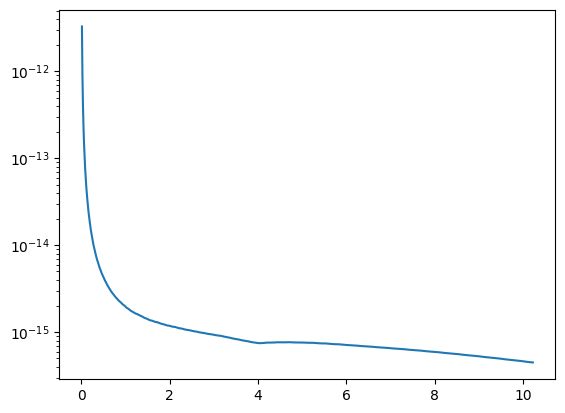

In [25]:
plt.semilogy(hdulist[1].data,hdulist[0].data[3])

Text(0, 0.5, 'Dust Temperature')

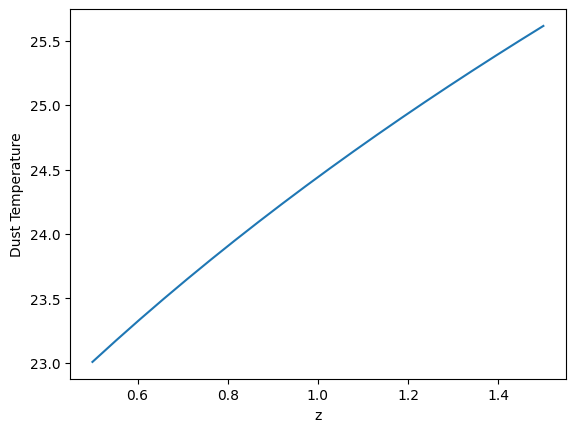

In [31]:
from galCIB.cib.default_snu import _compute_Tdust, _compute_nu0_z, _compute_prenu0, _compute_postnu0
tst_Tdust = _compute_Tdust(21.13, 0.21, cosmo.z)

plt.plot(cosmo.z,tst_Tdust)
plt.xlabel("z")
plt.ylabel("Dust Temperature")

Why $\gamma$ in dust should be sampled as a parameter.

In [32]:
zcib = np.arange(0,10, 0.1)
tst_Tdust_cib = _compute_Tdust(21.13, 0.29, zcib)
tst_nu0z_cib = _compute_nu0_z(1.98, tst_Tdust_cib, 1.7)

Text(0, 0.5, "$\\nu_{0} = \\nu_{0}'/(1+z)$ GHz")

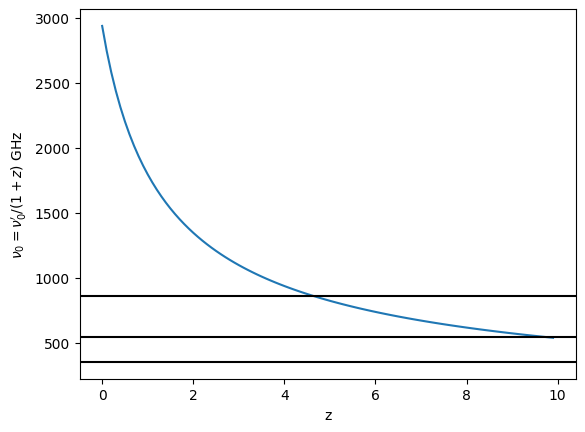

In [33]:
plt.plot(zcib, (tst_nu0z_cib/1e9)/(1+zcib))
plt.axhline(857, c = 'k')
plt.axhline(545, c = 'k')
plt.axhline(353, c = 'k')
plt.xlabel("z")
plt.ylabel(r"$\nu_{0} = \nu_{0}'/(1+z)$ GHz" )

Clearly, affects the two channels of Planck.

In [34]:
Td_K25 = _compute_Tdust(21.13, 0.21, cosmo.z)
nu0z_K25 = _compute_nu0_z(1.98, Td_K25, 1.7)

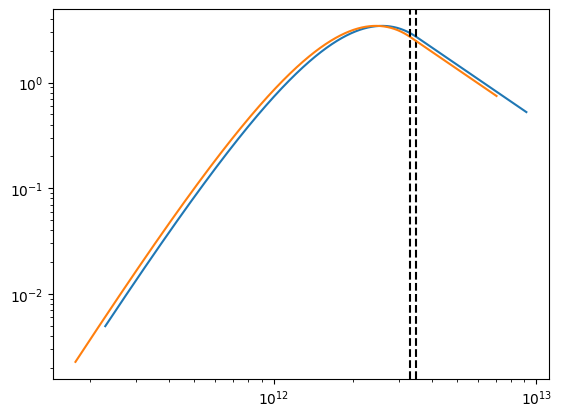

In [36]:
zidx=15
plt.loglog(cib_model.nu_prime[:,zidx],
         snu_m21(theta_snu)[:,zidx])

plt.axvline(nu0z_K25[zidx], c = 'k', ls = '--')

zidx=5
plt.loglog(cib_model.nu_prime[:,zidx],
         snu_m21(theta_snu)[:,zidx])
plt.axvline(nu0z_K25[zidx], c = 'k', ls = '--')

In [39]:
Theta_M21 = Theta(cib_model.nu_prime[:,zidx],cosmo.z[zidx])

In [42]:
nu0z_M21 = nu0_z(cosmo.z)

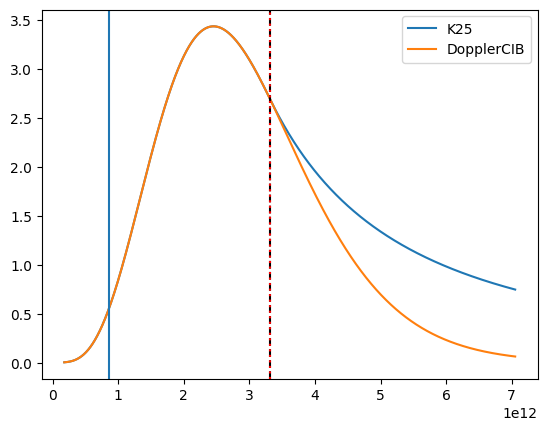

In [45]:
plt.plot(cib_model.nu_prime[:,zidx],
         snu_m21(theta_snu)[:,zidx],
         label='K25')

plt.plot(cib_model.nu_prime[:,zidx],
         Theta_M21*2.7,label='DopplerCIB')

plt.axvline(nu0z_K25[zidx], c = 'k', ls = '--')
plt.axvline(nu0z_M21[zidx], c = 'r', ls = 'dotted')

plt.axvline(857*1e9)

plt.legend(loc='best')

In [46]:
ls ../data/filters/HFI__avg_*

../data/filters/HFI__avg_100_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat*
../data/filters/HFI__avg_143_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat*
../data/filters/HFI__avg_217_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat*
../data/filters/HFI__avg_353_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat*
../data/filters/HFI__avg_545_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat*
../data/filters/HFI__avg_857_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat*


Text(0, 0.5, 'Filter Response Curve')

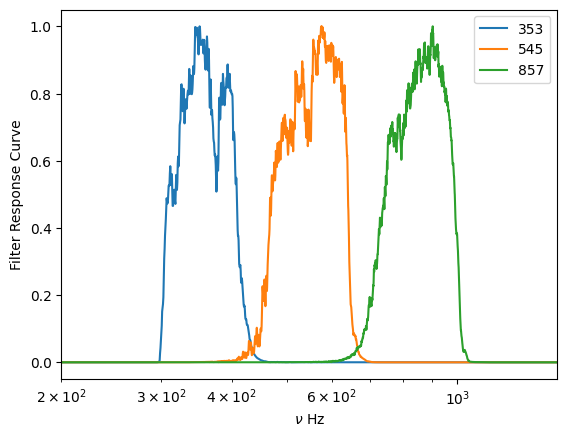

In [55]:
nu_list = ['353', '545', '857']

for nu in nu_list:
    fname = f"../data/filters/HFI__avg_{nu}_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat"
    filtarray = np.loadtxt(fname, usecols=(1,2))
    
    plt.semilogx(filtarray[:,0], filtarray[:,1],
             label = nu)
    
plt.xlim([2e2,1.5e3])
plt.legend(loc='best')
plt.xlabel(r"$\nu$ Hz")
plt.ylabel("Filter Response Curve")

In [56]:
# how I would do it

ghz = 1e9
wv = filtarray[:,0] * ghz # convert GHz to Hz 
fresponse = filtarray[:,1]

(200000000000.0, 1500000000000.0)

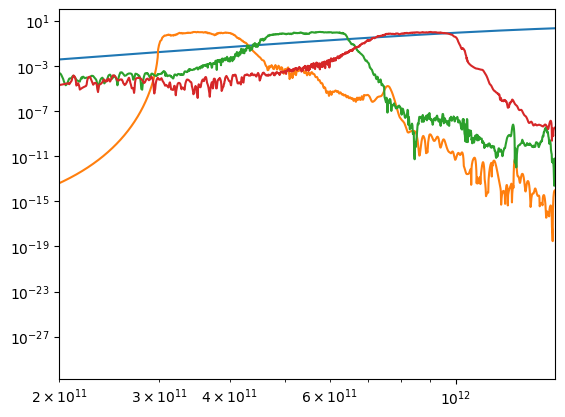

In [67]:
# now plot to see where the response curves fall for our hypothetical source 

hyp_wv = cib_model.nu_prime[:,zidx]
hyp_sed = snu_m21(theta_snu)[:,zidx] 
plt.plot(hyp_wv, hyp_sed,label='K25')

for nu in nu_list:
    fname = f"../data/filters/HFI__avg_{nu}_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat"
    filtarray = np.loadtxt(fname, usecols=(1,2))
    
    plt.loglog(filtarray[:,0]*ghz, filtarray[:,1],
             label = nu)
    
plt.xlim([2e11,1.5e12])

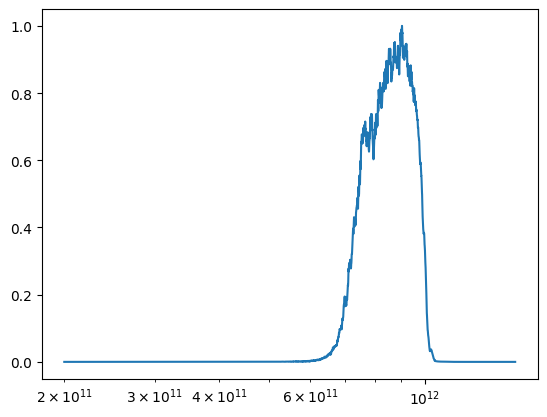

In [70]:
# each should result in a integrated flux calculation inside the response curve
# first bring everything in the common wavelength grid

# apply flag because beyond this the filters virtually have no response. Makes a faster interpolation. 
flag = (wv > 2e11) & (wv < 1.5e12)
wv_good = wv[flag]
fresponse_good = fresponse[flag]

plt.semilogx(wv_good, fresponse_good)

(200000000000.0, 1500000000000.0)

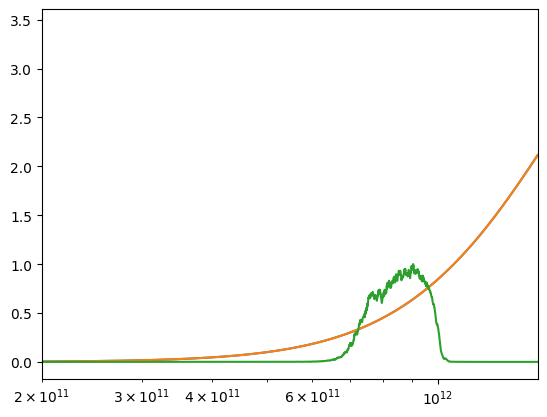

In [74]:
# Now let's interpolate on the same grid

hyp_sed_interp = np.interp(wv_good, hyp_wv, hyp_sed)

plt.plot(hyp_wv, hyp_sed)
plt.plot(wv_good, hyp_sed_interp)
plt.semilogx(wv_good, fresponse_good)
plt.xlim([2e11,1.5e12])

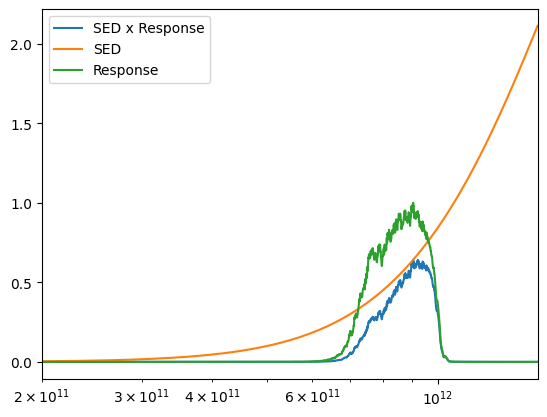

In [77]:
# now calculate the multiplication of the filter response 

sed_times_response = hyp_sed_interp * fresponse_good

plt.semilogx(wv_good, sed_times_response, label = 'SED x Response')
plt.plot(wv_good, hyp_sed_interp, label = 'SED')
plt.semilogx(wv_good, fresponse_good, label = 'Response')
plt.xlim([2e11,1.5e12])

plt.legend(loc='best')

In [152]:
from galCIB import CIBModel
from galCIB.galaxy import HODModel, get_hod_model

hod_model = get_hod_model("Zheng05", cosmo)

# List of filter files
planck_freqs = ['353', '545', '857'] # in GHz
fname = "/Users/tkarim/research/galCIB/data/filters/"

filter_paths = []
for freq in planck_freqs:
    filter_paths.append(f"{fname}HFI__avg_{freq}_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat")


# Initialize CIBModel using default sfr, snu, and filtering
cib = CIBModel(
    hod=hod_model,
    cosmo=cosmo,
    filtered=True,
    filter_files=filter_paths
)

# Evaluate snu or djc
theta_sfr = np.array([1, #eta_max 1 because Y23 cannot constrain this so the overall norm. goes to L0 in SED
                      11.78,0.40, #mu0_peak, mup_peak
                      2.47,0.45,1.93]) #sigmaM0, tau, zc
theta_snu = np.array([2.7, 1.98, 21.13, 0.21, 1.7]) #L0, beta_dust, T0, alpha_dust, gamma_dust
theta_hod = np.array([11.47, 1.22, 0.4])

# jnu = cib.compute_djc(theta_sfr, theta_snu)  # shape: (Nfilters, Nm, Nz)


In [156]:
jnu = cib.compute_djc(theta_sfr, theta_snu, theta_hod)  # shape: (Nfilters, Nm, Nz)

In [80]:
# Setup Power Spectra

In [9]:
theta_cen = np.array([5.47, 11.64, 0.30, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.41, 10**11.20, 10**13.84, 1]) # As, M0, M1, alpha_sat
#theta_prof = np.array([0.58, 6.14, 0.67]) # fexp, tau, lambda_NFW
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

In [10]:
from galCIB import PkBuilder

pow3d = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

AttributeError: 'PkBuilder' object has no attribute '_cache_galaxy_integral'

In [11]:
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1])
plt.loglog(cosmo.k, pow3d.Pgg_1h[:,1])
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1] + pow3d.Pgg_1h[:,1])

NameError: name 'pow3d' is not defined

In [84]:
from galCIB import AnalysisModel

In [85]:
elg_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d)

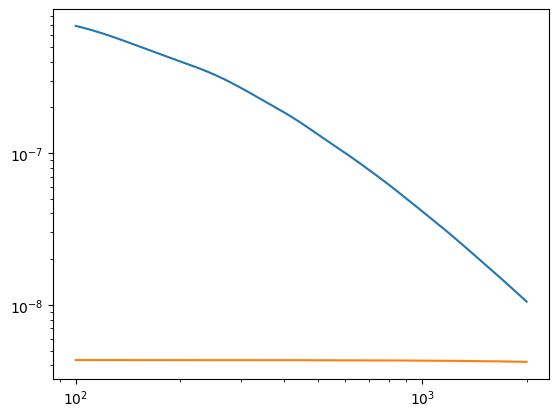

In [86]:
plt.loglog(elg_survey.ells, elg_cib.cl_gg_2h)
plt.loglog(elg_survey.ells, elg_cib.cl_gg_1h)

In [87]:
unwise_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d_unwise)

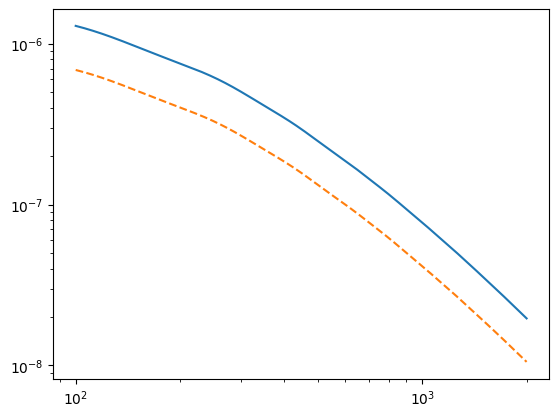

In [89]:
plt.loglog(elg_survey.ells, unwise_cib.cl_gg_2h)
#plt.loglog(elg_survey.ells, unwise_cib.cl_gg_1h)
plt.loglog(elg_survey.ells, elg_cib.cl_gg_2h,ls='--')

In [23]:
%%timeit 

zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
elg_survey = Survey(zs,pz,2.225,
                    ells, 1024,
                    name='elg')

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

cosmo = Cosmology(elg_survey.z, ks, Mh)

elg_survey.compute_windows(cosmo,True)

elg_hod_model = get_hod_model("DESI-ELG",elg_survey.z)

theta_sat = np.array([0.58, 6.14, 0.67])
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='mixed')

theta_cen = np.array([5.47, 11.64, 0.30, 0.1]) # gamma, log10Mc, sigmaM, Ac
theta_sat = np.array([0.41, 10**11.20, 10**13.84, 1]) # As, M0, M1, alpha_sat
theta_prof = np.array([0.58, 6.14, 0.67]) # fexp, tau, lambda_NFW

pow3d = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

elg_cib = AnalysisModel(cosmo,elg_survey,
                        pow3d)

/Users/tkarim/research/galCIB/src/galCIB/satprofile/profile.py:37: UserWarning: For the default mixed profile, theta should be [f_exp, tau_exp, lambda_NFW].
  warnings.warn(


274 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


About 7 hours for 100,000 calls

In [68]:
zs = np.linspace(0.5, 1.5, 20)

sigma = 0.79
mu = 0.4
pz = np.sqrt(2/np.pi)/sigma * np.exp(-0.5 * ((zs - mu)/sigma)**2)

# pz renorm such that integral p(z) dz = 1
pz = pz/(pz.sum() * np.diff(zs)[0])

LMIN = 100; LMAX=2000
ells = np.arange(LMIN, LMAX)
elg_survey = Survey(zs,pz,2.225,
                    ells, 1024,
                    name='elg')

ks = np.logspace(-3,1,500)
Mh = np.logspace(7,15,100)

cosmo = Cosmology(elg_survey.z, ks, Mh)

elg_survey.compute_windows(cosmo,True)

elg_hod_model = get_hod_model("Zheng05",cosmo)

theta_sat = np.array([10**7, 11.52, -0.02, 1]) #M0, mu0_M1, mup_M1, alpha_sat
elg_sat_profile = SatProfile(cosmo, theta_sat,
                             profile_type='nfw')

theta_cen = np.array([11.26, 2.43, 0.4]) # mu0_Mmin, mup_Mmin, sigma_lnM
theta_prof = np.array([0, 6.14, 1]) # fexp, tau, lambda_NFW

pow3d_unwise = PkBuilder(cosmo,elg_hod_model,elg_sat_profile,
                  theta_cen, theta_sat, theta_prof)

# elg_cib = AnalysisModel(cosmo,elg_survey,
#                         pow3d)

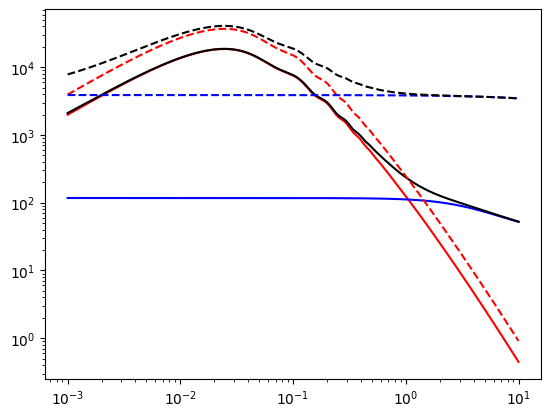

In [73]:
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1], ls = 'solid',c='r')
plt.loglog(cosmo.k, pow3d.Pgg_1h[:,1], ls = 'solid',c='b')
plt.loglog(cosmo.k, pow3d.Pgg_2h[:,1] + pow3d.Pgg_1h[:,1],
           ls = 'solid', c = 'k')


plt.loglog(cosmo.k, pow3d_unwise.Pgg_2h[:,1], ls ='dashed',c='r')
plt.loglog(cosmo.k, pow3d_unwise.Pgg_1h[:,1], ls ='dashed',c='b')
plt.loglog(cosmo.k, pow3d_unwise.Pgg_2h[:,1] + pow3d_unwise.Pgg_1h[:,1],
           ls ='dashed',c='k')

In [74]:
pow3d_unwise.Pgg_2h[:,1]/pow3d.Pgg_2h[:,1]

array([1.98689077, 1.98689065, 1.98689054, 1.98689042, 1.9868903 ,
       1.98689018, 1.98689006, 1.98688993, 1.98688981, 1.98688967,
       1.98688954, 1.98688941, 1.98688927, 1.98688913, 1.98688899,
       1.98688884, 1.98688869, 1.98688854, 1.98688839, 1.98688823,
       1.98688807, 1.98688791, 1.98688774, 1.98688757, 1.9868874 ,
       1.98688723, 1.98688705, 1.98688687, 1.98688668, 1.98688649,
       1.9868863 , 1.98688611, 1.98688591, 1.9868857 , 1.9868855 ,
       1.98688529, 1.98688507, 1.98688485, 1.98688463, 1.9868844 ,
       1.98688417, 1.98688394, 1.9868837 , 1.98688346, 1.98688321,
       1.98688295, 1.9868827 , 1.98688243, 1.98688217, 1.98688189,
       1.98688162, 1.98688133, 1.98688105, 1.98688075, 1.98688045,
       1.98688015, 1.98687984, 1.98687953, 1.9868792 , 1.98687888,
       1.98687854, 1.9868782 , 1.98687786, 1.98687751, 1.98687715,
       1.98687678, 1.98687641, 1.98687603, 1.98687564, 1.98687525,
       1.98687485, 1.98687444, 1.98687403, 1.9868736 , 1.98687

# Issues: 
- ~~Calculate $k$ for given $\ell$ per $z$, and re sample $P(k)$.~~ 
- ~~Integrate over the same $\ell$-to-$k$ grid~~
- ~~SFR Model test~~
- ~~SFR Model registry setup~~
- $S_{\nu}$ Model test
    - M21
    - ~~Y23~~
- $S_{\nu}$ Model registry setup 
    - M21
    - ~~Y23~~
- ~~$S_{\nu}$ filter turn-on option and utils to convolve with Planck filter~~
- $\theta$ update method in `AnalysisModel`
- Write submodule on MCMC and setup `loglikelihood` method 
- Run MCMC with just $C_{\rm gg}$
- $P_{\rm CIB-CIB}$ and $P_{\rm g-CIB}$
- Refactor `pk.py`; compute.py to contain all the Pk functions? 
- Include color correction in `AnalysisModel`
- Include `Survey`-specific $\ell$ binning in `AnalysisModel`.